# Train, predict and evaluate for COVID-19 cases

### Imports and files

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn import metrics

from helpers.regression import regression as RegressionHelper
from helpers.regression import plotDataSortedByActual

%matplotlib inline

PATH_DATA_CASES = './data/computed/cases.csv'

## Preparation

At first we are reading the data computed for this specific task.
This includes the number of total cases (and total cases per million) as well as information about the gdp, health care system, tourism and population.
We also print a correlation matrix to show our prepared data and how it's connected as well as the parts of the data itself.

We also remove all data with missing features.

In [2]:
df = pd.read_csv(PATH_DATA_CASES)
df.dropna(inplace=True)

In [3]:
print(df.shape)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(163, 9)


,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),lockdown_type,"International tourism, expenditures (% of total imports)"
total_cases,1.00,0.25,0.17,0.31,-0.02,0.08,0.03
total_cases_per_million,0.25,1.00,0.62,0.07,0.19,0.14,0.28
gdp_per_capita,0.17,0.62,1.00,0.20,0.28,0.30,0.20
health_expenditure_5y_avg,0.31,0.07,0.20,1.00,-0.06,0.17,0.05
Population density (people per sq. km of land area),-0.02,0.19,0.28,-0.06,1.00,0.03,0.03
lockdown_type,0.08,0.14,0.30,0.17,0.03,1.00,0.04
"International tourism, expenditures (% of total imports)",0.03,0.28,0.20,0.05,0.03,0.04,1.00


In [4]:
df.describe()

,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),lockdown_type,"International tourism, expenditures (% of total imports)"
count,1.630000e+02,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,5.401614e+04,1721.695454,19154.336908,6.458670,215.133291,0.684049,6.191332
std,2.118348e+05,3272.239036,19904.861742,2.522083,667.971201,0.437293,4.531365
min,4.000000e+00,1.867000,661.240000,2.224253,2.040609,0.000000,0.028524
25%,7.950000e+02,120.187000,4711.600500,4.539472,37.416563,0.000000,2.963447
50%,4.121000e+03,457.004000,12294.876000,6.289129,84.605985,1.000000,5.436048
75%,2.706100e+04,2026.134000,27467.146000,8.156820,207.885273,1.000000,8.817263
max,2.312302e+06,30684.193000,116935.600000,16.795518,7952.998418,1.000000,21.933781


In [5]:
df_with_countries = df.copy()
df.drop(["iso_code", "location", "total_cases"], axis=1, inplace=True)

## Linear Regression

Our first approach is to simply try and fit our data to a linear regression.
As you can see this fails miserably, because on one hand the scales of our data are completely different, e.g. indicators for the health care system are between 2.2 and 16.8 while GDP per capita is between 661 and 116936.
The impact of GDP per capita will be far greater than our health care can be, simply because of their respective scaling.
On the other hand our data tries to explain a real pandemic without considering most of the political decisions, we opted to include the lockdown data, but that simply was not enough.
This last point is easy to think about in hindsight, but even with more data on politics the current state of research simply does not allow to accurately predict the pandemic.

Mean Absolute Error: 1779.4370819997825
Mean Squared Error: 8628627.275297614
Root Mean Squared Error: 2937.4525145604675
R2 Score: 0.225188102071044


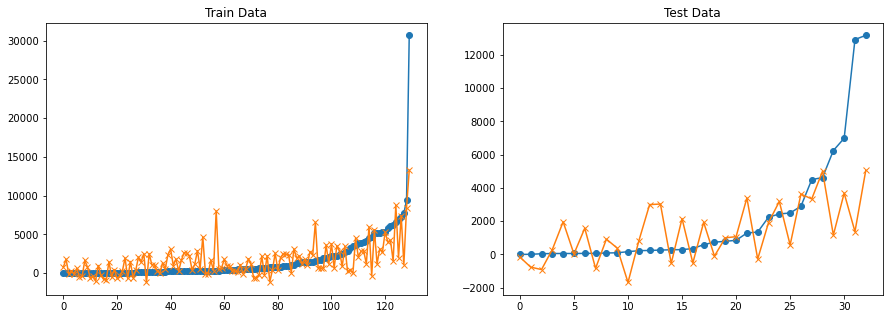

In [6]:
X = df.drop("total_cases_per_million", axis=1)
y = df["total_cases_per_million"]

RegressionHelper(X, y, LinearRegression(), 0.2, 42);

### Scaling and normalization

As we can see the results of our first try are _not great, not terrible_.
To improve the linear regression we decided to try out a scaled and a normalized version of the regression.
In both tries we also added polynomial features to account for the number of features we are using.

In [7]:
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=["total_cases_per_million", "gdp_per_capita",
                                            "health_expenditure_5y_avg","Population density (people per sq. km of land area)",
                                            "lockdown_type", "International tourism, expenditures (% of total imports)"])

x_normalized = normalize(df.values, axis=0, norm='max')
df_normalized = pd.DataFrame(x_normalized, columns=["total_cases_per_million", "gdp_per_capita",
                                            "health_expenditure_5y_avg","Population density (people per sq. km of land area)",
                                            "lockdown_type", "International tourism, expenditures (% of total imports)"])

#df_scaled.describe()
#df_normalized.describe()

In [8]:
X_scaled = df_scaled.drop("total_cases_per_million", axis=1)
y_scaled = df_scaled["total_cases_per_million"]

X_normalized = df_normalized.drop("total_cases_per_million", axis=1)
y_normalized = df_normalized["total_cases_per_million"]

### Polynomial features

In [9]:
poly3 = PolynomialFeatures(3)
x_poly_scaled = poly3.fit_transform(X_scaled)
df_poly_scaled = pd.DataFrame(x_poly_scaled)
X_poly_scaled = df_poly_scaled

x_poly_normalized = poly3.fit_transform(X_normalized)
df_poly_normalized = pd.DataFrame(x_poly_normalized)
X_poly_normalized = df_poly_normalized

### Performing regression with scaled and polynomial features

Mean Absolute Error: 0.1101289855931351
Mean Squared Error: 0.07065942222920925
Root Mean Squared Error: 0.2658184008476638
R2 Score: -4.973119638976623


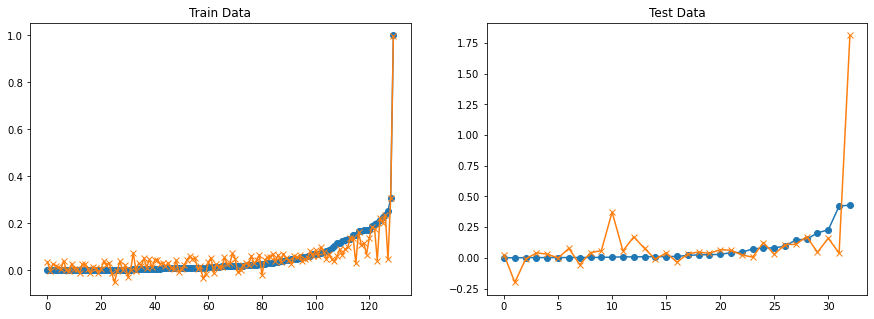

In [10]:
RegressionHelper(X_poly_scaled, y_scaled, LinearRegression(), 0.2, 42);

### Performing regression with normalized and polynomial features

Mean Absolute Error: 0.11080359442612173
Mean Squared Error: 0.07367895944701952
Root Mean Squared Error: 0.27143868450723735
R2 Score: -5.229131037059607


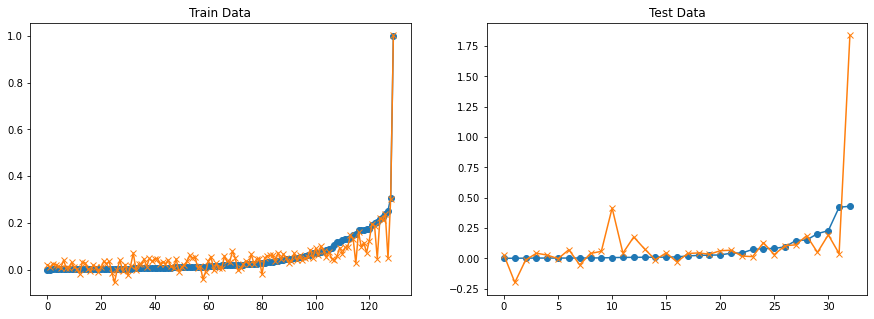

In [11]:
RegressionHelper(X_poly_normalized, y_normalized, LinearRegression(), 0.2, 42);

### Evaluation

After looking at a visualization of both approaches we can see that normalization and scaling don't differ that much.

MAE of around 0.11 means that on average the predicted value differs from the actual one by 0.11.
It shows us that the mean distance between the predicted and actual value is pretty high (because we are on a scale of 0 to 1 and most values are between 0 and 0.4).

MSE uses the same calculation as MRE with the twist of using squared values of the distance instead of the distance itself.
This is to better represent the effect outliers have on the graph.
That this score with 0.07 seems lower than MAE is because our values are between 0 and 1, thus squaring leads to smaller values.
To make it somehow comparable we can calculate the root of MSE which is much higher (0.27) and fits to the observation that we have some significant outliers.

R² is closely related to MSE but not quite the same.
It compares the variance of our predicted with the actual values and measures how well the label can be explained by the features.
It should be in a range of 0 and 1, where 0 means similar to predicting the average and 1 means perfect explanation.
We can see that our R² is negative (around -5) which means, according to sklearn docs, that it's worse than just predicting the average.


Normalization is recommended for sparse datasets, standardization for gaussian distributions. We use rescaling because it's the simplest of all methods and in theory should work well for us.

### Optimization

If we take a closer look at how the new regression performed and compare it to the first try, we can really see a lot of improvement, but also detect some overfitting, because of the number of training datasets and the number of features due to the introduction of 56 polynomial features (with dimension 3).


Because of the overfitting we decided to decrease the number of polynomial features by lowering the dimension to 2.

Mean Absolute Error: 0.04322312020445667
Mean Squared Error: 0.004213659444334995
Root Mean Squared Error: 0.06491270633962964
R2 Score: -0.12236457766067588


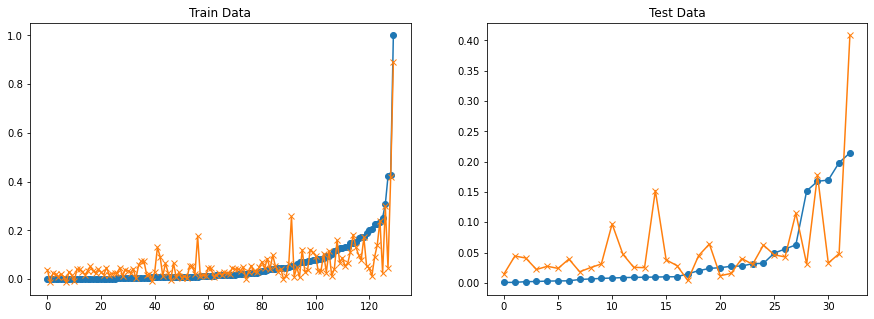

In [12]:
poly2 = PolynomialFeatures(2)
x_poly2_scaled = poly2.fit_transform(X_scaled)
df_poly2_scaled = pd.DataFrame(x_poly2_scaled)
X_poly2_scaled = df_poly2_scaled

[lin_reg, lin_reg_y_test, lin_reg_y_pred] = RegressionHelper(X_poly2_scaled, y_scaled, LinearRegression(), 0.2, 25)

By reducing the dimensions to 2 (when applying polynomial features) we have a worse performance on train data, but the prediction for our test data improves (MAE, MSE, RMSE decreased; R² moves towards 0).
Obviously we reduced overfitting.

As a last resort we decided to remove the outliers of our data, but that also deminishes our chance of reaching our goal, because we remove countries reporting _more accurate_ numbers than others and thus can not really predict how many cases a country of a certain size with certain attributes should have.
We will simply have a low number of cases for all countries, because that is more in line with our data.
Anyway, the following depicts the data if we'd remove the largest value and get everything closer together.
As you can see this does not improve our results, thus we try out another way of predicting the case numbers: Decision Trees.

Mean Absolute Error: 0.10063012913132978
Mean Squared Error: 0.0245976791847381
Root Mean Squared Error: 0.15683647275024423
R2 Score: -0.08216869392382709


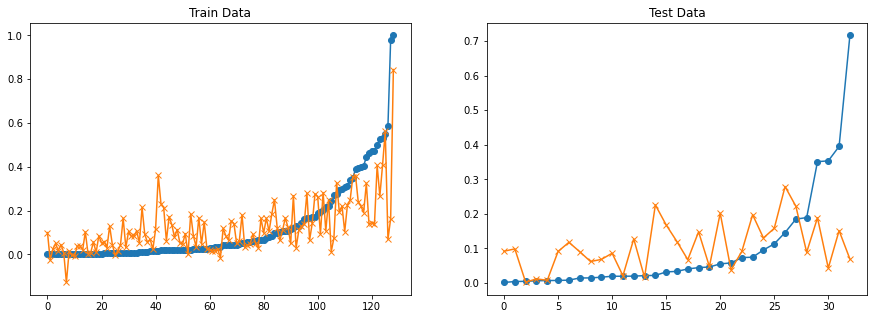

In [13]:
row_largest_value = df.nlargest(columns="total_cases_per_million",n=1).index[0]

x_wo_outlier = df.drop(row_largest_value).values
x_wo_outlier_scaled = min_max_scaler.fit_transform(x_wo_outlier)
df_wo_outlier_scaled = pd.DataFrame(x_wo_outlier_scaled, columns=["total_cases_per_million", "gdp_per_capita",
                                            "health_expenditure_5y_avg","Population density (people per sq. km of land area)",
                                            "lockdown_type", "International tourism, expenditures (% of total imports)"])
X_wo_outlier_scaled = df_wo_outlier_scaled.drop("total_cases_per_million", axis=1)
y_wo_outlier_scaled = df_wo_outlier_scaled["total_cases_per_million"]

poly2 = PolynomialFeatures(2)
x_poly2_scaled_wo_outlier = poly2.fit_transform(X_wo_outlier_scaled)
df_poly2_scaled_wo_outlier = pd.DataFrame(x_poly2_scaled_wo_outlier)
X_poly2_scaled_wo_outlier = df_poly2_scaled_wo_outlier

RegressionHelper(X_poly2_scaled_wo_outlier, y_wo_outlier_scaled, LinearRegression(), 0.2, 25);

## Decision Trees

With decision trees we try to more accurately predict what our linear regression model could not.
Our first try was to use the decision tree regressor provided by sklearn.
What we didn't know at first was depth of the tree and thus we overfitted quite nicely.

Mean Absolute Error: 0.0445846062727586
Mean Squared Error: 0.004534931518631046
Root Mean Squared Error: 0.06734190017092662
R2 Score: -0.20793969371953058


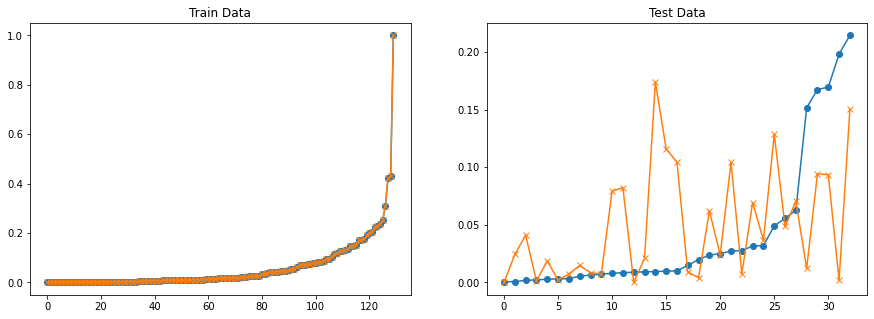

In [14]:
tree_1 = RegressionHelper(X_poly2_scaled, y_scaled, DecisionTreeRegressor(), 0.2, 25)[0]

Works really good on train data... ;)

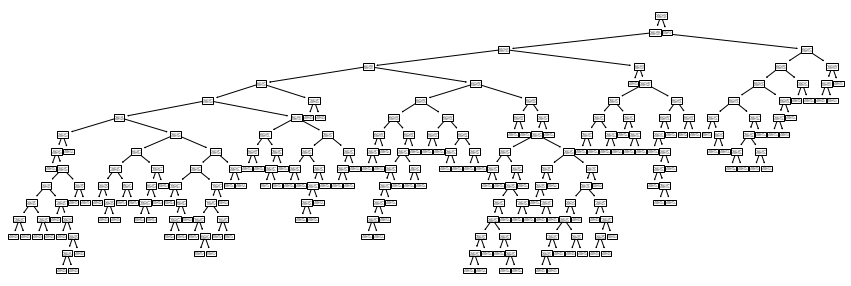

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
temp = plot_tree(tree_1, ax=ax)

After finding out how many different steps that tree had, we decided to limit the depth to a certain extend.
The results of this attempt don't look too promising as well. This is why we tried to create a random forest to check if we had a better chance of predicting the case numbers with another rather similar approach.

Mean Absolute Error: 0.03924676266814783
Mean Squared Error: 0.003850893162044071
Root Mean Squared Error: 0.062055565117433834
R2 Score: -0.025736924051796173


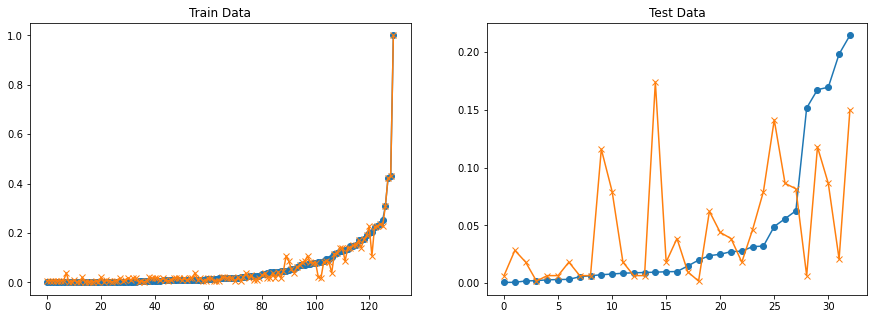

In [16]:
tree_regressor = RegressionHelper(X_poly2_scaled, y_scaled, DecisionTreeRegressor(max_depth=7), 0.2, 25)[0]

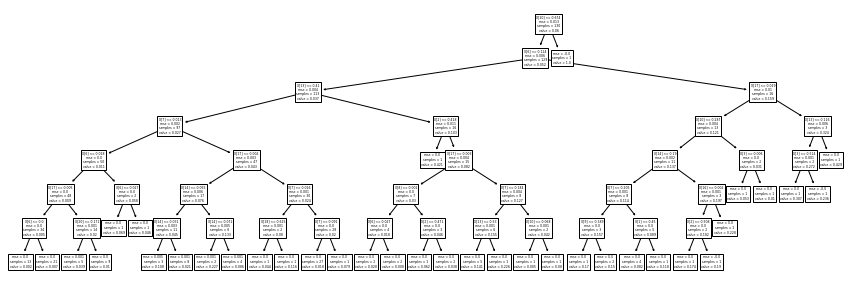

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
temp = plot_tree(tree_regressor, ax=ax)

## Random Forest

Our last approach of finding a meaningful start to predict the case numbers of COVID-19 for each country.

Mean Absolute Error: 0.03910662103762116
Mean Squared Error: 0.0033778610353338598
Root Mean Squared Error: 0.05811936884837842
R2 Score: 0.10026151272951978


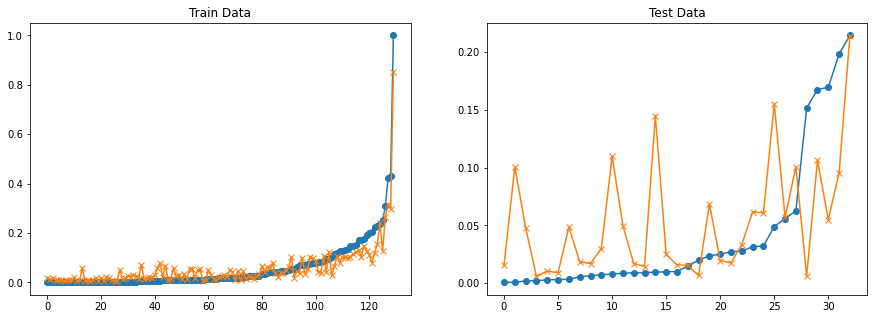

In [18]:
[rand_forest,
 rand_forest_y_test,
 rand_forest_y_pred] = RegressionHelper(X_poly2_scaled, y_scaled,
                                        RandomForestRegressor(n_estimators=42, max_depth=5), 0.2, 25)

## Comparison between Linear Regression and Random Forest

                         Linear Regression 	 Random Forest
Mean Absolute Error:     0.0432 		 0.0391
Mean Squared Error:      0.0042 		 0.0034
Root Mean Squared Error: 0.0649 		 0.0581
R2 Score:                -0.1224 		 0.1003


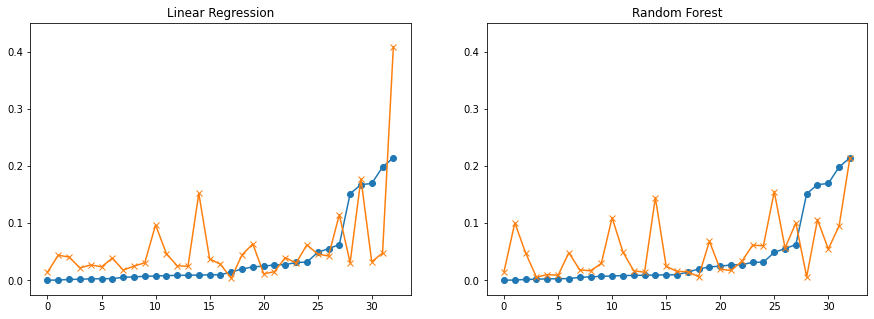

In [20]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plotDataSortedByActual(ax1, lin_reg_y_test, lin_reg_y_pred, "Linear Regression", -0.025, 0.45)
plotDataSortedByActual(ax2, rand_forest_y_test, rand_forest_y_pred, "Random Forest", -0.025, 0.45)

print('                        ', 'Linear Regression', '\t', 'Random Forest')
print('Mean Absolute Error:    ', round(metrics.mean_absolute_error(lin_reg_y_test, lin_reg_y_pred), 4),
     "\t\t", round(metrics.mean_absolute_error(rand_forest_y_test, rand_forest_y_pred), 4))
print('Mean Squared Error:     ', round(metrics.mean_squared_error(lin_reg_y_test, lin_reg_y_pred), 4),
     "\t\t", round(metrics.mean_squared_error(rand_forest_y_test, rand_forest_y_pred), 4))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(lin_reg_y_test, lin_reg_y_pred)), 4),
     "\t\t", round(np.sqrt(metrics.mean_squared_error(rand_forest_y_test, rand_forest_y_pred)), 4))
print('R2 Score:               ', round(metrics.r2_score(lin_reg_y_test, lin_reg_y_pred), 4),
     "\t\t", round(metrics.r2_score(rand_forest_y_test, rand_forest_y_pred), 4))

Random Forest works slightly better than Linear Regression.

## Last words

In the end all our results may have failed, but we believe this is because of the data.
We simply cannot predict case numbers that are far more reliable on actual taken measures by each country than on their theoretical preparedness.
Another important aspect of this is the authenticity of the used data, because many countries with either a poor health care system or other motives do not report accurate numbers.
We tried to combat this with the health care expenditures, but that simply does not account for all different factors that are at play.